<a href="https://colab.research.google.com/github/Kavindutharaka/kgirls-stylegan/blob/main/KGirls_StyleGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets -q
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import opendatasets as od
import time
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ds = od.download("https://www.kaggle.com/datasets/vkehfdl1/kidf-kpop-idol-dataset-female")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: elfinkavi
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/vkehfdl1/kidf-kpop-idol-dataset-female


100%|██████████| 1.03G/1.03G [01:08<00:00, 16.2MB/s]


In [ ]:

!pip install imageio -q
!pip install git+https://github.com/tensorflow/docs -q

  Preparing metadata (setup.py) ... done


In [ ]:
import glob
import imageio
import PIL
from PIL import Image
from IPython import display

In [ ]:
BATCH_SIZE = 8
IMG_SIZE = (128, 128)  # Increased resolution for StyleGAN
latent_dim = 512
epochs = 1000

In [ ]:
data_dir = "/content/kidf-kpop-idol-dataset-female/HQ_512x512/HQ_512x512"

In [ ]:
def load_images_from_directory(directory, target_size=(128, 128)):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            img_resized = img.resize(target_size, Image.ANTIALIAS)
            images.append(np.array(img_resized))
    return np.array(images)

In [ ]:
data = load_images_from_directory(data_dir, target_size=(128, 128))
print(f"Shape of data: {data.shape}")

<ipython-input-7-6eae057f7a5b>:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize(target_size, Image.ANTIALIAS)


Shape of data: (5591, 128, 128, 3)


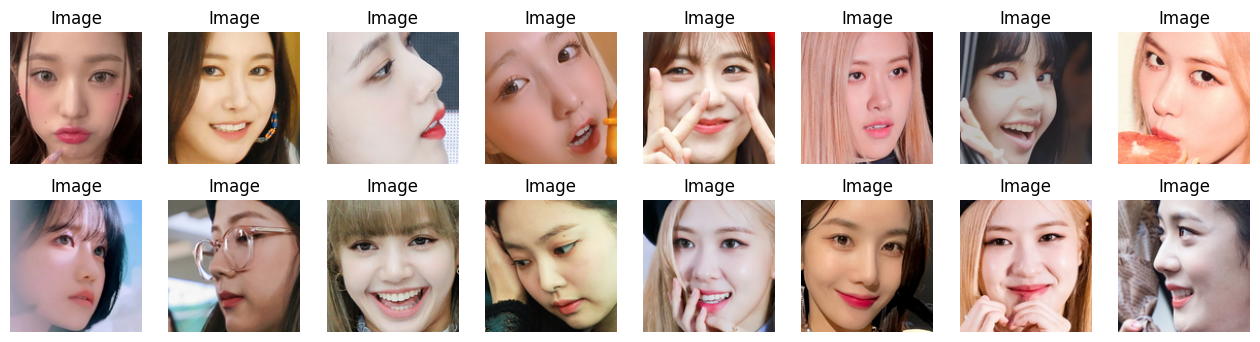

In [ ]:
plt.figure(figsize=(16, 4))
for i in range(16):
    ax = plt.subplot(2, 8, i + 1)
    plt.imshow(data[i].astype('uint8'))
    plt.title('Image')
    plt.axis('off')

plt.show()

In [ ]:
def preprocess_image(image):
    # Normalize image to [-1, 1]
    image = tf.cast(image, tf.float32)  # Cast image to float32
    image = image / 127.5 - 1.0
    return image

In [ ]:
def prepare_dataset(images, batch_size=8, buffer_size=1000):
    dataset = tf.data.Dataset.from_tensor_slices(images)
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
dataset = prepare_dataset(data, batch_size=BATCH_SIZE)

In [ ]:
from tensorflow.keras import layers, Model


In [ ]:
def build_mapping_network(latent_dim=512, depth=8):
    inputs = layers.Input(shape=(latent_dim,))
    x = inputs
    for _ in range(depth):
        x = layers.Dense(latent_dim, activation='relu')(x)
    return Model(inputs, x, name='MappingNetwork')

In [ ]:
class AdaIN(layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(AdaIN, self).__init__()
        self.epsilon = epsilon

    def call(self, inputs):
        content, style = inputs
        mean_c, var_c = tf.nn.moments(content, axes=[1, 2], keepdims=True)
        mean_s, var_s = tf.nn.moments(style, axes=[1, 2], keepdims=True)

        std_c = tf.sqrt(var_c + self.epsilon)
        std_s = tf.sqrt(var_s + self.epsilon)

        normalized_content = (content - mean_c) / std_c
        return normalized_content * std_s + mean_s

In [ ]:
def build_synthesis_network(resolution=128, latent_dim=512):
    resolution_log2 = int(np.log2(resolution))
    inputs = layers.Input(shape=(latent_dim,))

    x = layers.Dense(4 * 4 * latent_dim, activation='relu')(inputs)
    x = layers.Reshape((4, 4, latent_dim))(x)

    for res in range(3, resolution_log2 + 1):
        x = layers.UpSampling2D()(x)
        x = layers.Conv2D(latent_dim, kernel_size=3, padding='same', activation='relu')(x)

        style = layers.Dense(latent_dim)(inputs)
        style = layers.Reshape((1, 1, latent_dim))(style)

        x = AdaIN()([x, style])

        x = layers.Conv2D(latent_dim, kernel_size=3, padding='same', activation='relu')(x)
        x = AdaIN()([x, style])

    output_image = layers.Conv2D(3, kernel_size=1, padding='same', activation='tanh')(x)
    return Model(inputs, output_image, name='SynthesisNetwork')

In [ ]:
def build_discriminator(resolution=128, base_filters=64):
    resolution_log2 = int(np.log2(resolution))
    inputs = layers.Input(shape=(resolution, resolution, 3))

    x = inputs
    for res in range(resolution_log2, 2, -1):
        x = layers.Conv2D(base_filters * (2 ** (resolution_log2 - res)), kernel_size=3, padding='same', activation='leaky_relu')(x)
        x = layers.Conv2D(base_filters * (2 ** (resolution_log2 - res)), kernel_size=3, padding='same', activation='leaky_relu')(x)
        x = layers.AveragePooling2D(pool_size=(2, 2))(x)  # Added pool_size argument

    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)  # Binary classification: real or fake

    return Model(inputs, x, name='Discriminator')

In [ ]:
class StyleGAN(Model):
    def __init__(self, latent_dim=512, resolution=128):
        super(StyleGAN, self).__init__()
        self.mapping_network = build_mapping_network(latent_dim)
        self.synthesis_network = build_synthesis_network(resolution, latent_dim)

    def call(self, inputs):
        w = self.mapping_network(inputs)
        image = self.synthesis_network(w)
        return image

In [ ]:
stylegan = StyleGAN()
discriminator = build_discriminator()

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.0, beta_2=0.99)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.0, beta_2=0.99)

In [ ]:
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
output_dir = "/content/drive/My Drive/GAN/Korean_Girl_StyleGan"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
import time
start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    for real_images in dataset:

        with tf.GradientTape() as disc_tape:

            # Ensure that the batch size is consistent for both real and generated images
            random_latent_vectors = tf.random.normal(shape=(real_images.shape[0], latent_dim))  # Use the batch size of real_images
            generated_images = stylegan(random_latent_vectors)


            real_output = discriminator(real_images)
            fake_output = discriminator(generated_images)


            real_labels = tf.ones_like(real_output)
            fake_labels = tf.zeros_like(fake_output)
            disc_loss = bce_loss(real_labels, real_output) + bce_loss(fake_labels, fake_output)


        grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

        with tf.GradientTape() as gen_tape:

            # Use the same batch size as in the discriminator step
            generated_images = stylegan(random_latent_vectors)


            fake_output = discriminator(generated_images)

            # Adjust the shape of real_labels to match fake_output
            real_labels = tf.ones_like(fake_output)  # Match the shape of fake_output
            gen_loss = bce_loss(real_labels, fake_output)

        grads = gen_tape.gradient(gen_loss, stylegan.trainable_variables)
        generator_optimizer.apply_gradients(zip(grads, stylegan.trainable_variables))


    generated_images = (generated_images + 1) * 127.5
    for i, img in enumerate(generated_images):
        img = Image.fromarray(img.numpy().astype('uint8'))
        img.save(f"{output_dir}/epoch_{epoch + 1}_img_{i}.png")

    epoch_end_time = time.time()
    epoch_duration = (epoch_end_time - epoch_start_time) / 60

    total_elapsed_time = (epoch_end_time - start_time) / 60

    print(f'Epoch {epoch + 1}/{epochs}, Discriminator Loss: {disc_loss.numpy()}, Generator Loss: {gen_loss.numpy()}')

    print(f'Epoch {epoch + 1}/{epochs}, Discriminator Loss: {disc_loss.numpy()}, Generator Loss: {gen_loss.numpy()}')
    print(f'Epoch Time: {epoch_duration:.2f} minutes')
    print(f'Total Time Elapsed: {total_elapsed_time:.2f} minutes')

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/1000, Discriminator Loss: 2.3447864055633545, Generator Loss: 5.147063732147217
Epoch 1/1000, Discriminator Loss: 2.3447864055633545, Generator Loss: 5.147063732147217
Epoch Time: 27.37 minutes
Total Time Elapsed: 27.37 minutes
